In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from keras.models import Model
from keras.layers import Input, LSTM, Dense, Dropout
import matplotlib.pyplot as plt
from keras.optimizers import Adam

In [2]:
# 设置中文字体显示
import matplotlib
matplotlib.rcParams['font.sans-serif'] = ['SimHei']  # 使用黑体
matplotlib.rcParams['axes.unicode_minus'] = False  # 正常显示负号

# 数据预处理

在本节中，我们将加载数据集，对其进行清洗，并将其转换为可用于进一步分析的格式。

In [3]:
# 加载并预处理数据集
raw_data = pd.read_csv('Data/指数行情.csv')
raw_data['日期'] = pd.to_datetime(raw_data['日期'], format='%Y/%m/%d')
for column in raw_data.columns:
    if (raw_data[column].dtype == 'object'):
        raw_data[column] = raw_data[column].astype('float64')
raw_data.interpolate(method='linear', inplace=True)
raw_data.to_csv('Data/指数行情_processed.csv', index=False)

# 特征工程

在这里，我们将计算对数收益率和滚动波动率，以便为建模做好准备。

In [4]:
# 计算对数收益率和滚动波动率
log_returns = np.log(raw_data.iloc[:, 1:] / raw_data.iloc[:, 1:].shift(1))
log_returns['日期'] = raw_data['日期']
log_returns.dropna(inplace=True)
log_returns.set_index('日期', inplace=True)
rolling_volatility = pd.DataFrame()
for asset in log_returns.columns:
    rolling_volatility[f'{asset}_volatility'] = log_returns[asset].rolling(window=20).std()
rolling_volatility.dropna(inplace=True)
r_and_v = log_returns.merge(rolling_volatility, left_index=True, right_index=True)
r_and_v.dropna(inplace=True)

In [5]:
# 为建模准备数据
lookback_window = 60
X_features, y_returns, y_volatility, y_returns_short, y_returns_hist, y_volatility_hist = [], [], [], [], [], []
for i in range(lookback_window, len(r_and_v) - 20):
    X_features.append(r_and_v.iloc[i - lookback_window:i, :].values)
    y_returns.append(r_and_v.iloc[i:i + 20, :14].sum().values)  # 收益率的 target 为 20 日窗口的总和
    y_returns_hist.append(r_and_v.iloc[i-20:i, :14].sum().values)  # 历史收益率的为 20 日窗口的历史数据
    y_volatility.append(r_and_v.iloc[i + 19, 14:].values)  # 波动率的 target 为第 20 日的滚动相关性
    y_volatility_hist.append(r_and_v.iloc[i-60:i, :14].std().values * np.sqrt(1 / 3))  # 历史波动率的为 60 日窗口的历史数据
    y_returns_short.append(r_and_v.iloc[i, :14].values)  # 短期收益率的 target 为未来一期
X_features = np.array(X_features)
y_returns = np.array(y_returns)
y_volatility = np.array(y_volatility)
y_returns_short = np.array(y_returns_short)
y_returns_hist = np.array(y_returns_hist)
y_volatility_hist = np.array(y_volatility_hist)

In [6]:
y_returns.shape, y_volatility.shape, y_returns_short.shape, y_returns_hist.shape, y_volatility_hist.shape

((1732, 14), (1732, 14), (1732, 14), (1732, 14), (1732, 14))

# 模型训练与评估

本节重点训练每个资产类别的 LSTM 模型，并使用各种指标评估其性能。

In [7]:
# 训练集和测试集划分
split_index = int(0.8 * len(X_features))
X_train, X_test = X_features[:split_index], X_features[split_index:]
y_train_returns, y_test_returns = y_returns[:split_index], y_returns[split_index:]
y_train_volatility, y_test_volatility = y_volatility[:split_index], y_volatility[split_index:]
y_train_returns_short, y_test_returns_short = y_returns_short[:split_index], y_returns_short[split_index:]

# 收益率模型建立与训练

In [8]:
# 建立并训练收益率的 LSTM 模型
training_history_returns = {}
for i, column in enumerate(r_and_v.columns[:14]):
    print(f'训练收益率的 LSTM 模型: {column}')
    y_train_column = y_train_returns[:, i].reshape(-1, 1)
    inputs = Input(shape=(lookback_window, X_train.shape[2]))
    x = LSTM(64, activation='relu', return_sequences=True)(inputs)
    x = Dropout(0.4)(x)
    x = LSTM(32, activation='relu')(x)
    x = Dropout(0.3)(x)
    x = Dense(16, activation='relu')(x)
    outputs = Dense(1)(x)
    lstm_model = Model(inputs=inputs, outputs=outputs)
    adam_optimizer = Adam(learning_rate=0.0001)
    lstm_model.compile(optimizer=adam_optimizer, loss='mse')
    history = lstm_model.fit(
        X_train, y_train_column,
        epochs=50, batch_size=64,
        validation_split=0.3,
        verbose=1
    )
    training_history_returns[column] = history

训练收益率的 LSTM 模型: 沪深300
Epoch 1/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - loss: 0.0031 - val_loss: 0.0017
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - loss: 0.0031 - val_loss: 0.0017
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0028 - val_loss: 0.0017
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0028 - val_loss: 0.0017
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0030 - val_loss: 0.0017
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0030 - val_loss: 0.0017
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0028 - val_loss: 0.0016
Epoch 5/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0028 - val_loss: 0.0016
Epoch 5/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0031 - val_loss: 0.0016
Epoch 6/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0031 - val_loss: 0.0016
Epoch 6/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0031 - val_loss: 0.0016
Epoch 7/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29

# 收益率模型训练结果可视化

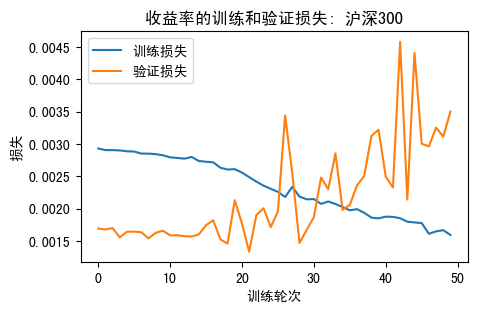

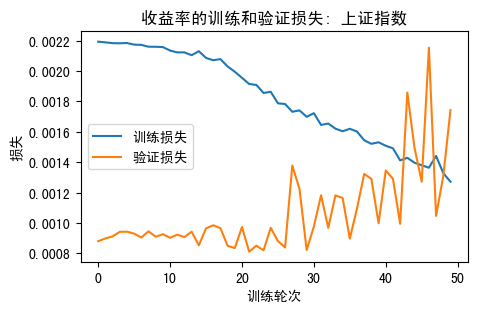

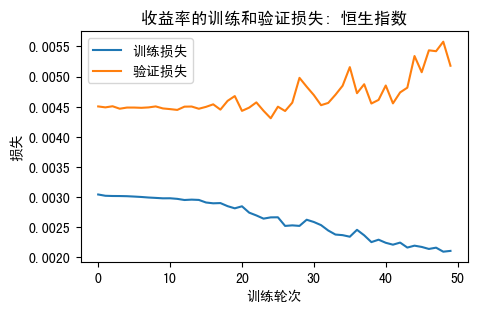

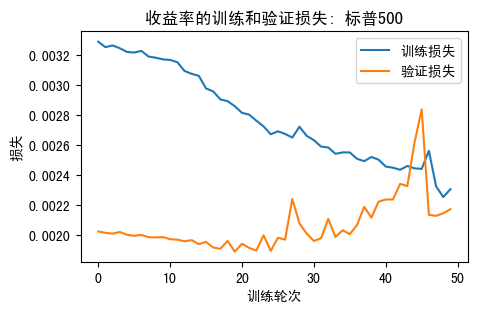

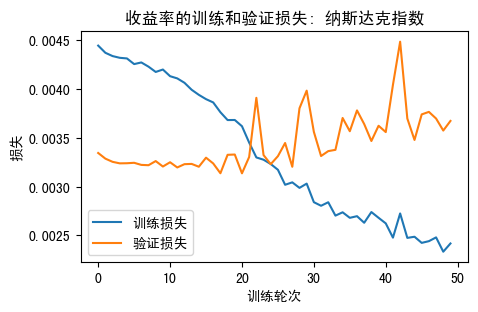

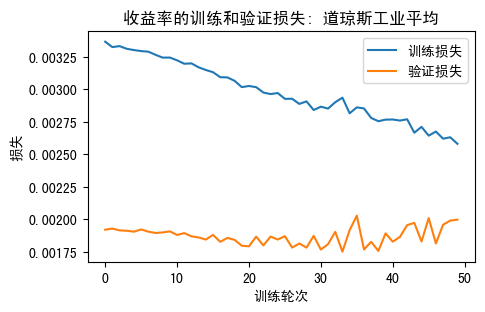

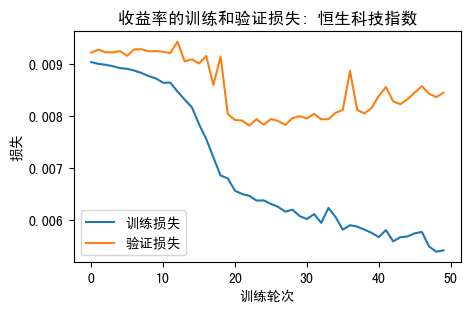

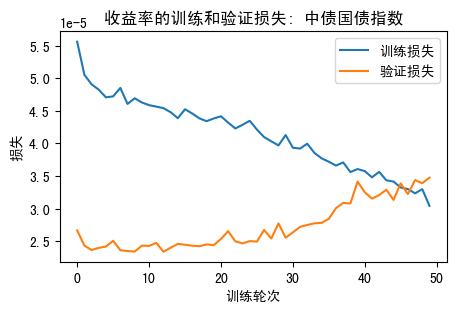

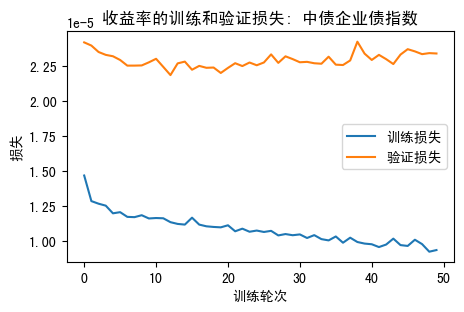

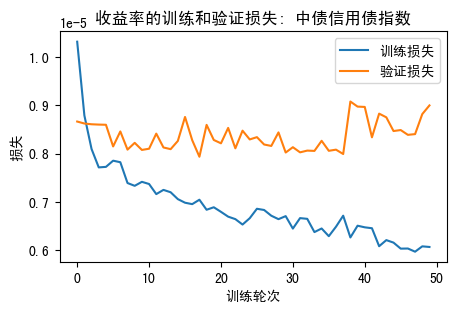

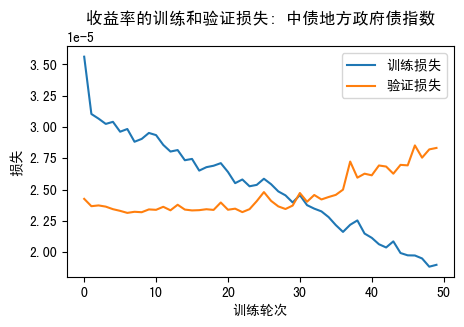

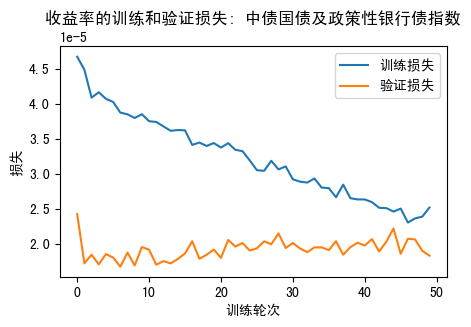

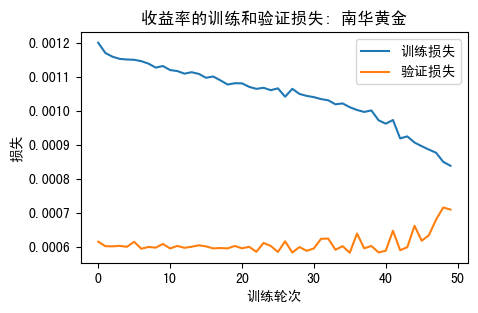

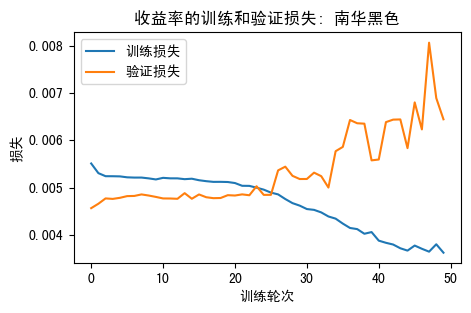

In [9]:
# 可视化收益率模型的训练和验证损失
for column, history in training_history_returns.items():
    plt.figure(figsize=(5, 3))
    plt.plot(history.history['loss'], label='训练损失')
    plt.plot(history.history['val_loss'], label='验证损失')
    plt.title(f'收益率的训练和验证损失: {column}')
    plt.xlabel('训练轮次')
    plt.ylabel('损失')
    plt.legend()
    plt.show()

# 收益率模型评估

In [10]:
# 评估收益率模型的预测结果
evaluation_metrics_returns = {}
for i, column in enumerate(r_and_v.columns[:14]):
    y_test_column = y_test_returns[:, i].reshape(-1, 1)
    predictions = training_history_returns[column].model.predict(X_test)
    mae = mean_absolute_error(y_test_column, predictions)
    mse = mean_squared_error(y_test_column, predictions)
    r2 = r2_score(y_test_column, predictions)
    evaluation_metrics_returns[column] = {'平均绝对误差 (MAE)': mae, '均方误差 (MSE)': mse, '决定系数 (R²)': r2}

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


In [11]:
evaluation_metrics_returns

{'沪深300': {'平均绝对误差 (MAE)': 0.04584085168479889,
  '均方误差 (MSE)': 0.003930287321210608,
  '决定系数 (R²)': -0.048922785083097775},
 '上证指数': {'平均绝对误差 (MAE)': 0.046426978914429366,
  '均方误差 (MSE)': 0.0036031953347218236,
  '决定系数 (R²)': -0.18975993299311766},
 '恒生指数': {'平均绝对误差 (MAE)': 0.05996624754142656,
  '均方误差 (MSE)': 0.006087910648221747,
  '决定系数 (R²)': -0.05054475786648793},
 '标普500': {'平均绝对误差 (MAE)': 0.03407228685889137,
  '均方误差 (MSE)': 0.00183062214451933,
  '决定系数 (R²)': -0.3407254754458411},
 '纳斯达克指数': {'平均绝对误差 (MAE)': 0.055562678572988036,
  '均方误差 (MSE)': 0.004670021368581466,
  '决定系数 (R²)': -0.8409337674078663},
 '道琼斯工业平均': {'平均绝对误差 (MAE)': 0.02955414298658216,
  '均方误差 (MSE)': 0.0013379155066685258,
  '决定系数 (R²)': -0.1625410806230978},
 '恒生科技指数': {'平均绝对误差 (MAE)': 0.09359484740068595,
  '均方误差 (MSE)': 0.01412314451278497,
  '决定系数 (R²)': -0.09940070826633196},
 '中债国债指数': {'平均绝对误差 (MAE)': 0.00669673827576147,
  '均方误差 (MSE)': 8.345417028074059e-05,
  '决定系数 (R²)': -0.3045814580195072},
 '中债企

In [24]:
evaluation_metrics_returns_df = pd.DataFrame(evaluation_metrics_returns).T

In [25]:
evaluation_metrics_returns_df

,平均绝对误差 (MAE),均方误差 (MSE),决定系数 (R²)
沪深300,0.045841,0.003930,-0.048923
上证指数,0.046427,0.003603,-0.189760
恒生指数,0.059966,0.006088,-0.050545
标普500,0.034072,0.001831,-0.340725
纳斯达克指数,0.055563,0.004670,-0.840934
道琼斯工业平均,0.029554,0.001338,-0.162541
恒生科技指数,0.093595,0.014123,-0.099401
中债国债指数,0.006697,0.000083,-0.304581
中债企业债指数,0.002757,0.000012,-0.192277
中债信用债指数,0.002155,0.000009,-0.151965


# 波动率模型建立与训练

In [12]:
# 建立并训练波动率的 LSTM 模型
training_history_volatility = {}
for i, column in enumerate(r_and_v.columns[14:]):
    print(f'训练波动率的 LSTM 模型: {column}')
    y_train_column = y_train_volatility[:, i].reshape(-1, 1)
    inputs = Input(shape=(lookback_window, X_train.shape[2]))
    x = LSTM(64, activation='relu', return_sequences=True)(inputs)
    x = Dropout(0.4)(x)
    x = LSTM(32, activation='relu')(x)
    x = Dropout(0.3)(x)
    x = Dense(16, activation='relu')(x)
    outputs = Dense(1)(x)
    lstm_model = Model(inputs=inputs, outputs=outputs)
    adam_optimizer = Adam(learning_rate=0.0001)
    lstm_model.compile(optimizer=adam_optimizer, loss='mse')
    history = lstm_model.fit(
        X_train, y_train_column,
        epochs=50, batch_size=128,
        validation_split=0.3,
        verbose=1
    )
    training_history_volatility[column] = history

训练波动率的 LSTM 模型: 沪深300_volatility
Epoch 1/50
Epoch 1/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 79ms/step - loss: 9.1593e-05 - val_loss: 5.9057e-06
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 79ms/step - loss: 9.1593e-05 - val_loss: 5.9057e-06
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 3.0039e-05 - val_loss: 2.1158e-05
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 3.0039e-05 - val_loss: 2.1158e-05
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 2.8222e-05 - val_loss: 1.9760e-05
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 2.8222e-05 - val_loss: 1.9760e-05
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 2.5695e-05 - val_loss: 8.0996e-06
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 2.5695e-05 - val_loss: 8.0996e-06
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 2.2499e-05 - val_loss: 6.2166e-06
Epoch 6/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 2.2499e-05 - val_loss: 6.2166e-06
Epoch 6/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/st

# 波动率模型训练结果可视化

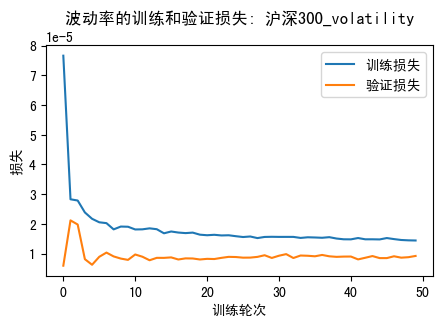

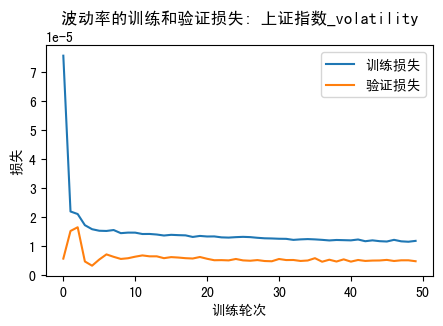

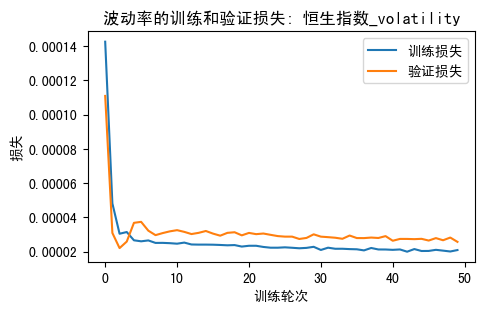

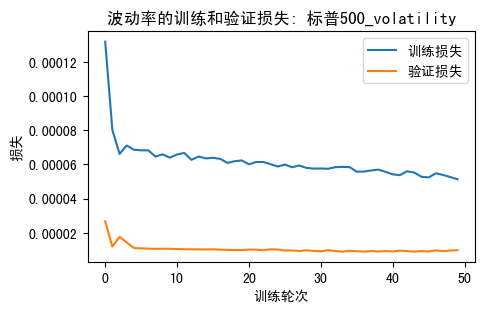

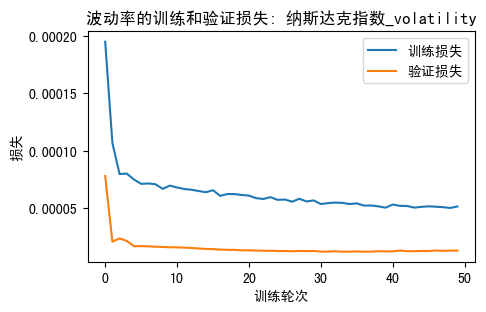

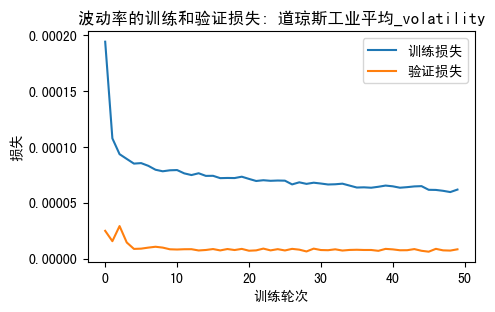

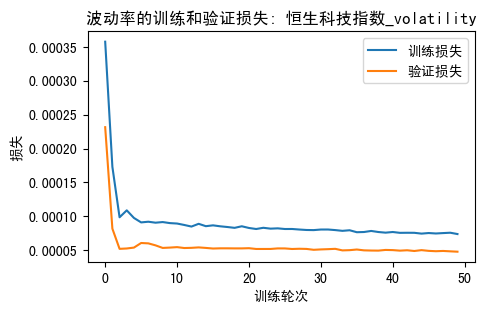

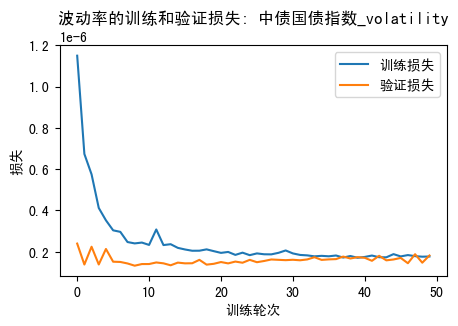

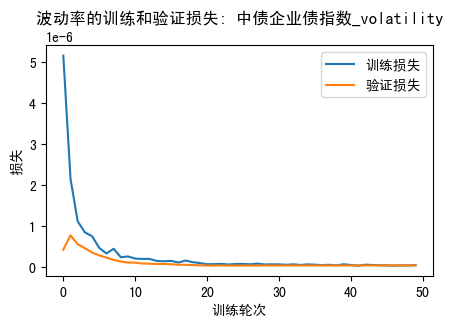

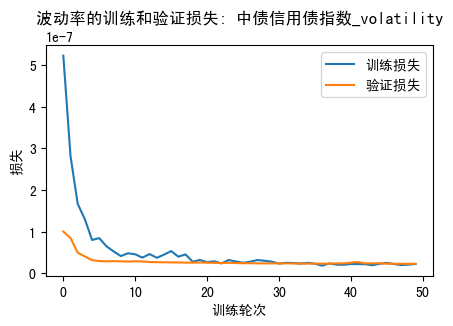

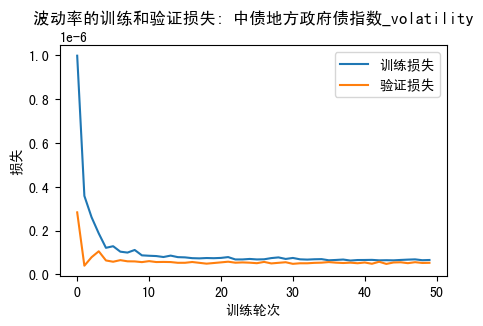

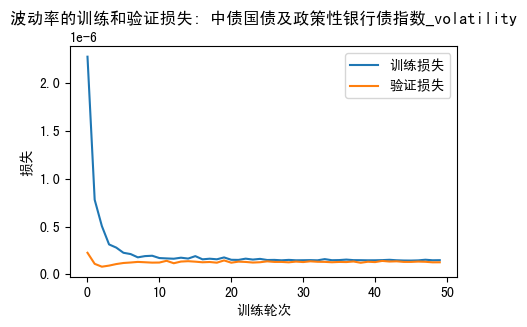

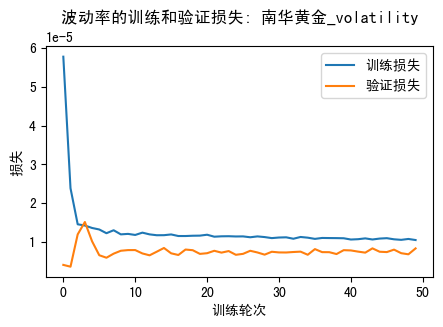

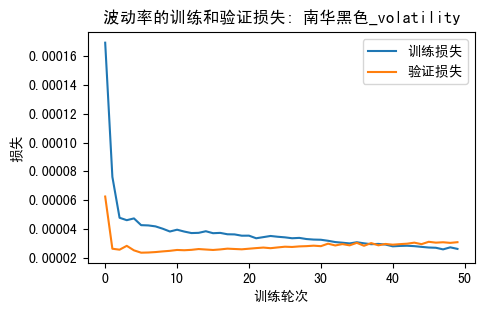

In [13]:
# 可视化波动率模型的训练和验证损失
for column, history in training_history_volatility.items():
    plt.figure(figsize=(5, 3))
    plt.plot(history.history['loss'], label='训练损失')
    plt.plot(history.history['val_loss'], label='验证损失')
    plt.title(f'波动率的训练和验证损失: {column}')
    plt.xlabel('训练轮次')
    plt.ylabel('损失')
    plt.legend()
    plt.show()

# 波动率模型评估

In [14]:
# 评估波动率模型的预测结果
evaluation_metrics_volatility = {}
for i, column in enumerate(r_and_v.columns[14:]):
    y_test_column = y_test_volatility[:, i].reshape(-1, 1)
    predictions = training_history_volatility[column].model.predict(X_test)
    mae = mean_absolute_error(y_test_column, predictions)
    mse = mean_squared_error(y_test_column, predictions)
    r2 = r2_score(y_test_column, predictions)
    evaluation_metrics_volatility[column] = {'平均绝对误差 (MAE)': mae, '均方误差 (MSE)': mse, '决定系数 (R²)': r2}

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


In [15]:
evaluation_metrics_volatility

{'沪深300_volatility': {'平均绝对误差 (MAE)': 0.0037122167414447077,
  '均方误差 (MSE)': 2.4492250117452725e-05,
  '决定系数 (R²)': -0.04293186342418909},
 '上证指数_volatility': {'平均绝对误差 (MAE)': 0.0029818333729817125,
  '均方误差 (MSE)': 1.925548611367238e-05,
  '决定系数 (R²)': 0.045848194186151714},
 '恒生指数_volatility': {'平均绝对误差 (MAE)': 0.0046546379691461744,
  '均方误差 (MSE)': 4.909461723919174e-05,
  '决定系数 (R²)': -0.568923641574903},
 '标普500_volatility': {'平均绝对误差 (MAE)': 0.0035570142420193137,
  '均方误差 (MSE)': 2.3665062721868313e-05,
  '决定系数 (R²)': 0.2954684666956635},
 '纳斯达克指数_volatility': {'平均绝对误差 (MAE)': 0.003825924899430152,
  '均方误差 (MSE)': 3.408055274987352e-05,
  '决定系数 (R²)': 0.25258732104487225},
 '道琼斯工业平均_volatility': {'平均绝对误差 (MAE)': 0.003244725972906585,
  '均方误差 (MSE)': 1.732224012877411e-05,
  '决定系数 (R²)': 0.25416942320630587},
 '恒生科技指数_volatility': {'平均绝对误差 (MAE)': 0.005734991493877174,
  '均方误差 (MSE)': 6.766258178806768e-05,
  '决定系数 (R²)': -0.02077065959696367},
 '中债国债指数_volatility': {'平均绝对误差 (MAE)': 

In [22]:
evaluation_metrics_volatility_df = pd.DataFrame(evaluation_metrics_volatility).T

In [23]:
evaluation_metrics_volatility_df

,平均绝对误差 (MAE),均方误差 (MSE),决定系数 (R²)
沪深300_volatility,0.003712,2.449225e-05,-0.042932
上证指数_volatility,0.002982,1.925549e-05,0.045848
恒生指数_volatility,0.004655,4.909462e-05,-0.568924
标普500_volatility,0.003557,2.366506e-05,0.295468
纳斯达克指数_volatility,0.003826,3.408055e-05,0.252587
道琼斯工业平均_volatility,0.003245,1.732224e-05,0.254169
恒生科技指数_volatility,0.005735,6.766258e-05,-0.020771
中债国债指数_volatility,0.000463,4.306807e-07,-0.344883
中债企业债指数_volatility,0.000129,3.619367e-08,-0.028033
中债信用债指数_volatility,0.000137,3.763466e-08,-0.335949


# 短期收益率模型建立与训练

In [16]:
# 建立并训练短期收益率的 LSTM 模型
training_history_returns_short = {}
for i, column in enumerate(r_and_v.columns[:14]):   
    print(f'训练短期收益率的 LSTM 模型: {column}')
    y_train_column = y_train_returns_short[:, i].reshape(-1, 1)
    inputs = Input(shape=(lookback_window, X_train.shape[2]))
    x = LSTM(64, activation='relu', return_sequences=True)(inputs)
    x = Dropout(0.4)(x)
    x = LSTM(32, activation='relu')(x)
    x = Dropout(0.3)(x)
    x = Dense(16, activation='relu')(x)
    outputs = Dense(1)(x)
    lstm_model = Model(inputs=inputs, outputs=outputs)
    adam_optimizer = Adam(learning_rate=0.0001)
    lstm_model.compile(optimizer=adam_optimizer, loss='mse')
    history = lstm_model.fit(
        X_train, y_train_column,
        epochs=50, batch_size=64,
        validation_split=0.3,
        verbose=1
    )
    training_history_returns_short[column] = history

训练短期收益率的 LSTM 模型: 沪深300
Epoch 1/50
Epoch 1/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - loss: 1.5318e-04 - val_loss: 8.2416e-05
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - loss: 1.5318e-04 - val_loss: 8.2416e-05
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 1.5207e-04 - val_loss: 8.2591e-05
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 1.5207e-04 - val_loss: 8.2591e-05
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 1.5113e-04 - val_loss: 8.3358e-05
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 1.5113e-04 - val_loss: 8.3358e-05
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 1.5047e-04 - val_loss: 8.2589e-05
Epoch 5/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 1.5047e-04 - val_loss: 8.2589e-05
Epoch 5/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 1.4446e-04 - val_loss: 8.3573e-05
Epoch 6/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 1.4446e-04 - val_loss: 8.3573e-05
Epoch 6/50
16/16 ━━━━━━━━━━━━━━━━━━

# 短期收益率模型训练结果可视化

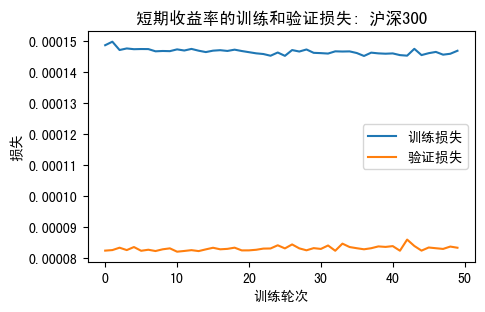

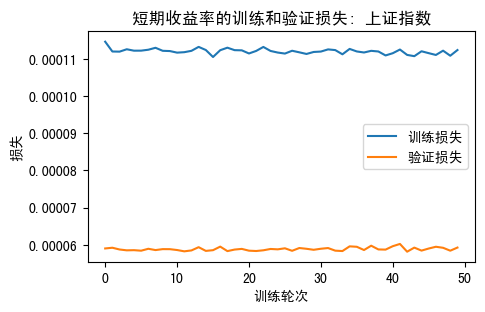

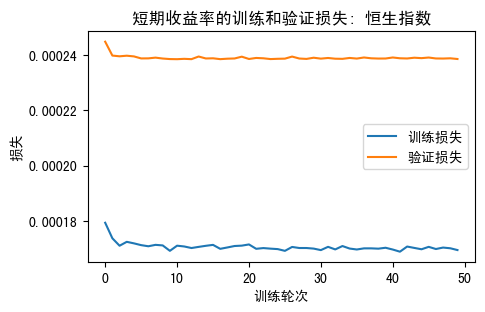

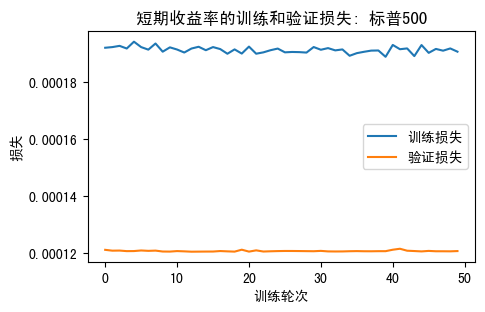

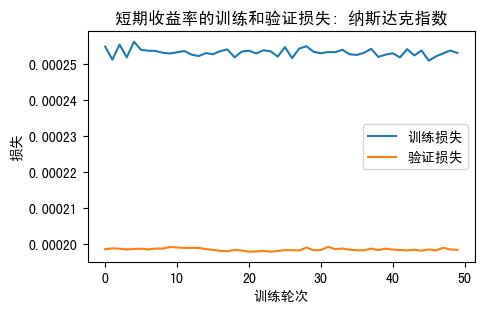

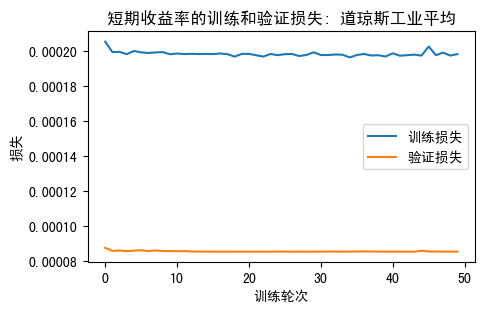

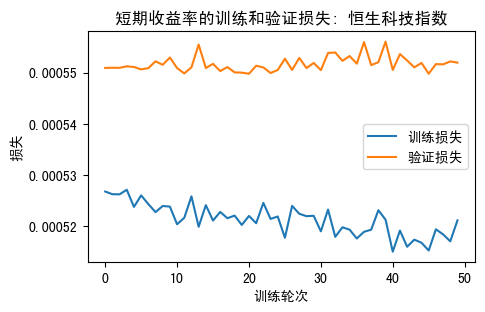

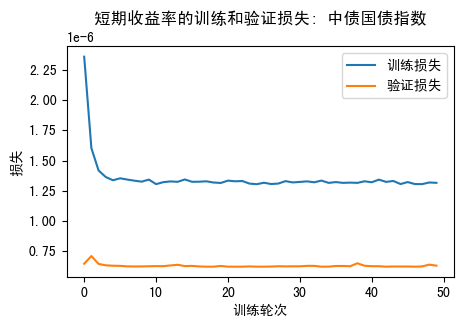

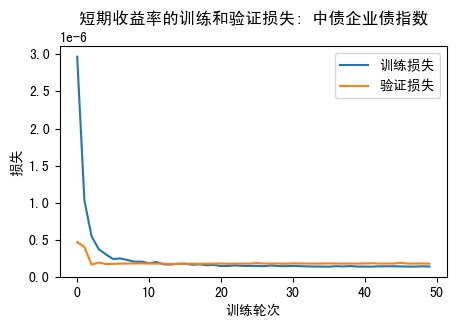

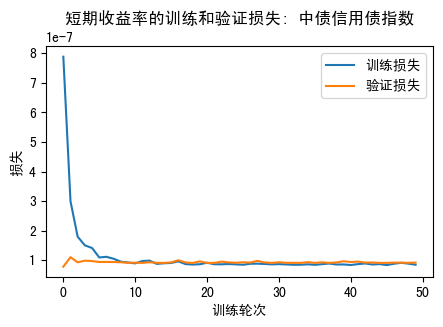

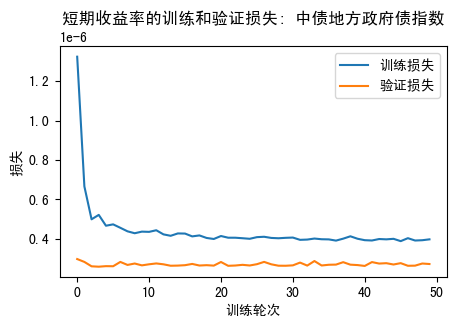

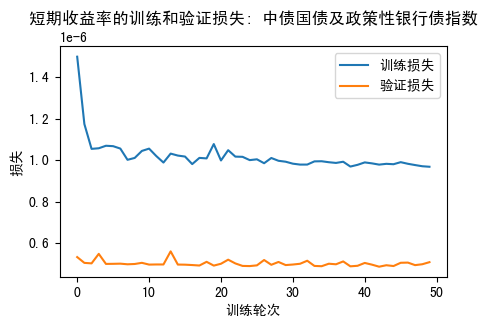

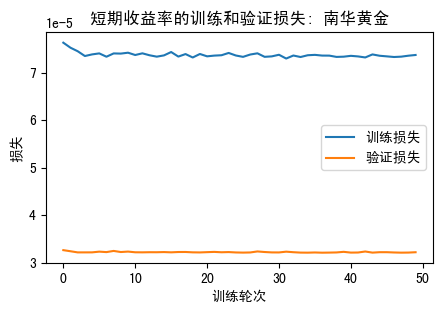

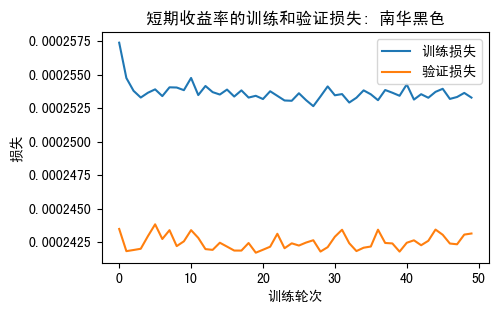

In [17]:
# 可视化短期收益率模型的训练和验证损失
for column, history in training_history_returns_short.items():
    plt.figure(figsize=(5, 3))
    plt.plot(history.history['loss'], label='训练损失')
    plt.plot(history.history['val_loss'], label='验证损失')
    plt.title(f'短期收益率的训练和验证损失: {column}')
    plt.xlabel('训练轮次')
    plt.ylabel('损失')
    plt.legend()
    plt.show()

# 短期收益率模型评估

In [18]:
# 评估短期收益率模型的预测结果
evaluation_metrics_returns_short = {}
for i, column in enumerate(r_and_v.columns[:14]):
    y_test_column = y_test_returns_short[:, i].reshape(-1, 1)
    predictions = training_history_returns_short[column].model.predict(X_test)
    mae = mean_absolute_error(y_test_column, predictions)
    mse = mean_squared_error(y_test_column, predictions)
    r2 = r2_score(y_test_column, predictions)
    evaluation_metrics_returns_short[column] = {'平均绝对误差 (MAE)': mae, '均方误差 (MSE)': mse, '决定系数 (R²)': r2}

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


In [19]:
evaluation_metrics_returns_short

{'沪深300': {'平均绝对误差 (MAE)': 0.007592690820085953,
  '均方误差 (MSE)': 0.0001298140925151179,
  '决定系数 (R²)': 0.00040797156975669324},
 '上证指数': {'平均绝对误差 (MAE)': 0.007159271198446558,
  '均方误差 (MSE)': 0.00011670105792889701,
  '决定系数 (R²)': -0.00025946498526008277},
 '恒生指数': {'平均绝对误差 (MAE)': 0.011131427554091269,
  '均方误差 (MSE)': 0.0002503829488160164,
  '决定系数 (R²)': -0.0050614838454718925},
 '标普500': {'平均绝对误差 (MAE)': 0.006498202141582782,
  '均方误差 (MSE)': 0.00010949205014984347,
  '决定系数 (R²)': -0.002234019867819015},
 '纳斯达克指数': {'平均绝对误差 (MAE)': 0.009167210711463447,
  '均方误差 (MSE)': 0.00019497045854140814,
  '决定系数 (R²)': 0.0009690831342626938},
 '道琼斯工业平均': {'平均绝对误差 (MAE)': 0.0057365653027871225,
  '均方误差 (MSE)': 8.21476380115037e-05,
  '决定系数 (R²)': 0.00022866721018854896},
 '恒生科技指数': {'平均绝对误差 (MAE)': 0.016562657895735695,
  '均方误差 (MSE)': 0.0005383372551401471,
  '决定系数 (R²)': -0.001897762324780894},
 '中债国债指数': {'平均绝对误差 (MAE)': 0.0009910167344322827,
  '均方误差 (MSE)': 2.1258528101168456e-06,
  '决定系数 (R

# 历史法与模型预测收益率的MAE对比

本节将`y_returns_hist`（历史法预测值）与模型预测值分别和测试集真实值进行 MAE 对比。

In [20]:
mae_hist_vs_true = {}
mae_model_vs_true = {}
for i, column in enumerate(r_and_v.columns[:14]):
    # 历史法预测值与真实值
    mae_hist = mean_absolute_error(y_test_returns[:, i], y_returns_hist[split_index:, i])
    # 模型预测值与真实值
    model_pred = training_history_returns[column].model.predict(X_test).flatten()
    mae_model = mean_absolute_error(y_test_returns[:, i], model_pred)
    mae_hist_vs_true[column] = mae_hist
    mae_model_vs_true[column] = mae_model

mae_compare_df = pd.DataFrame({
    '历史法MAE': mae_hist_vs_true,
    '模型预测MAE': mae_model_vs_true
})
mae_compare_df

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


,历史法MAE,模型预测MAE
沪深300,0.060903,0.045841
上证指数,0.056888,0.046427
恒生指数,0.086439,0.059966
标普500,0.035170,0.034072
纳斯达克指数,0.046515,0.055563
道琼斯工业平均,0.038286,0.029554
恒生科技指数,0.126616,0.093595
中债国债指数,0.008587,0.006697
中债企业债指数,0.003146,0.002757
中债信用债指数,0.002867,0.002155


# 历史法与模型预测波动率的MAE对比

本节将`y_volatility_hist`（历史法预测值）与模型预测值分别和测试集真实波动率进行 MAE 对比。

In [21]:
mae_vol_hist_vs_true = {}
mae_vol_model_vs_true = {}
for i, column in enumerate(r_and_v.columns[14:]):
    # 历史法预测值与真实值
    mae_hist = mean_absolute_error(y_test_volatility[:, i], y_volatility_hist[split_index:, i])
    # 模型预测值与真实值
    model_pred = training_history_volatility[column].model.predict(X_test).flatten()
    mae_model = mean_absolute_error(y_test_volatility[:, i], model_pred)
    mae_vol_hist_vs_true[column] = mae_hist
    mae_vol_model_vs_true[column] = mae_model

mae_vol_compare_df = pd.DataFrame({
    '历史法MAE': mae_vol_hist_vs_true,
    '模型预测MAE': mae_vol_model_vs_true
})
mae_vol_compare_df

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
11/11 ━

,历史法MAE,模型预测MAE
沪深300_volatility,0.004373,0.003712
上证指数_volatility,0.004261,0.002982
恒生指数_volatility,0.006700,0.004655
标普500_volatility,0.004716,0.003557
纳斯达克指数_volatility,0.006460,0.003826
道琼斯工业平均_volatility,0.004124,0.003245
恒生科技指数_volatility,0.009967,0.005735
中债国债指数_volatility,0.000641,0.000463
中债企业债指数_volatility,0.000159,0.000129
中债信用债指数_volatility,0.000141,0.000137
